In [1]:
import numpy as np
import pickle as pk
import pandas as pd
import sys

from collections import OrderedDict

from matplotlib import pyplot as plt
import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable

sys.path.insert(1, '../')

from asteroid_utils_pixell import  get_desig

import requests, json

import seaborn as sns
sns.set_theme(style="ticks")

from pixell import utils

from scipy.interpolate import interp1d

from astropy.time import Time
from astropy.table import QTable
import astropy.units as u

import ephem

[nia-jupyter.scinet.local:62718] pml_ucx.c:285  Error: UCP worker does not support MPI_THREAD_MULTIPLE


In [2]:
def inv_var(data, variances):
    ave = 0
    var = 0
    for i in range(len(data)):
        ave += data[i]/variances[i]
        var += 1/variances[i]
    return ave/var, 1/var

In [3]:
def compute_alpha(ra_sun, dec_sun, d_earth_sun, ra_ast, dec_ast, d_earth_ast):
    sun_earth_vec = utils.ang2rect([ra_sun, dec_sun])*d_earth_sun
    earth_ast_vec = utils.ang2rect([ra_ast, dec_ast])*d_earth_ast
    sun_ast_vec = earth_ast_vec - sun_earth_vec
    angle = utils.vec_angdist(-earth_ast_vec, -earth_ast_vec+sun_earth_vec)

    return angle

In [4]:
with open('../pks/ast_stats.pk', 'rb') as f:
    ast_dir = pk.load(f)
    


In [1]:
def plot_lc(name, tstart, tend, ast_dir):
    norm_flux, norm_err = ast_dir[name]["flux_090"]
    info = np.load('/gpfs/fs0/project/r/rbond/sigurdkn/actpol/ephemerides/objects/{}.npy'.format(name)).view(np.recarray)
    orbit   = interp1d(info.ctime, [utils.unwind(info.ra*utils.degree), 
            info.dec*utils.degree, info.r, info.rsun, info.ang*utils.arcsec], kind=3)
    
    norm_flux *= (120/10)**2 #Beam fill factor adjustment
    norm_err *= (120/10)**2
    
    t = Time([tstart, tend], format='isot', scale='utc')
    
    tspace = np.linspace(t[0].unix, t[1].unix, int(1e5))
    
    ra_ast, dec_ast, delta_earth, delta_sun, ignore_ang = orbit(tspace)
    
    djd_time = utils.ctime2djd(tspace)
    sun = ephem.Sun()
    alpha = np.zeros(len(tspace))
    for i in range(len(alpha)): #Fucking ephem is not vectorized
        sun.compute(djd_time[i])

        alpha[i] = compute_alpha(sun.ra, sun.dec, sun.earth_distance, ra_ast[i], dec_ast[i], delta_earth[i])
        alpha[i] *= (180/np.pi)
    
    
    weight = 1/(delta_sun**(-1/2) * delta_earth**(-2) *10**(-0.004*alpha))
    return tspace, norm_flux / weight, norm_err / weight, ra_ast, dec_ast

In [6]:
name = "Diotima"
ts, flux_diotima, err_diotima, ra_diotima, dec_diotima = plot_lc(name, "2025-01-01T00:00:00.00","2025-07-01T00:00:00.00", ast_dir)

name = "Davida"
ts, flux_davida, err_davida, ra_davida, dec_davida = plot_lc(name, "2025-01-01T00:00:00.00","2025-07-01T00:00:00.00", ast_dir)

ts = Time(ts, format='unix', scale = 'utc')

In [7]:
months = OrderedDict()
months["1"]="January"
months["2"]="February"
months["3"]="March"
months["4"]="April"
months["5"]="May"
months["6"]="June"
months["7"]="July"
#months["8"]="Aug"
#months["9"]="Sept"
#months["10"]="Oct"
#months["11"]="Nov"
#months["12"]="Dec"
month_flags = np.zeros(len(months.keys()))
temp_ts = ts.ymdhms
for i in range(len(months.keys())):
    for j in range(len(temp_ts)):
        if str(temp_ts[j][1]) == list(months.keys())[i]:
          month_flags[i] = int(j)
          break
            
month_flags[-1] = len(temp_ts)-1
month_flags = np.array(month_flags, dtype=int)

In [8]:
month_flags

array([    0, 17127, 32597, 49724, 66298, 83425, 99999])

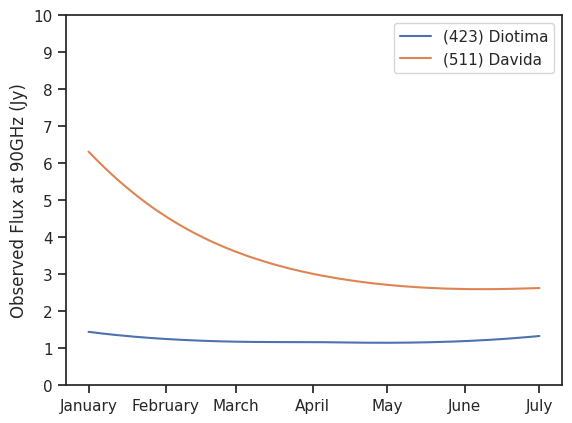

In [9]:
fig, ax1 = plt.subplots()

plt.plot(ts.unix, flux_diotima/1000, label = "(423) Diotima")
plt.plot(ts.unix, flux_davida/1000, label = "(511) Davida")
plt.legend()

plt.xticks(ts[month_flags].value, months.values())
plt.ylabel("Observed Flux at 90GHz (Jy)")
yticks = np.arange(0, 11, 1)
plt.yticks(yticks)

#ax2 = ax1.twinx()
#mn, mx = ax1.get_ylim()
#ax2.set_ylim(mn/81*(25/144)*1000, mx/81*(25/144)*1000)
#ax2.set_ylabel('Observed Flux at 30GHz (mJy)')
#ax2.set_yticks(np.round(yticks/81*(25/144)*1000, 1))

plt.savefig("fluxes.pdf", dpi=300, bbox_inches = "tight")
plt.show()

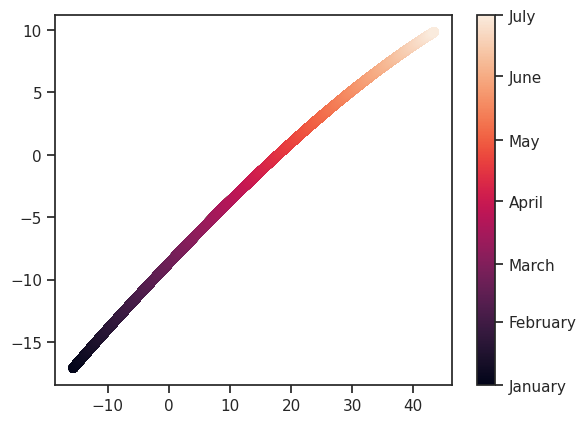

In [11]:
fig, ax = plt.subplots()

cax = plt.scatter(utils.unwind(ra_diotima)/utils.degree, dec_diotima/utils.degree, c=ts.unix)
cbar = fig.colorbar(cax, ticks=ts[month_flags].value)#, orientation='horizontal')
cbar.ax.set_yticklabels(months.values())
plt.show()

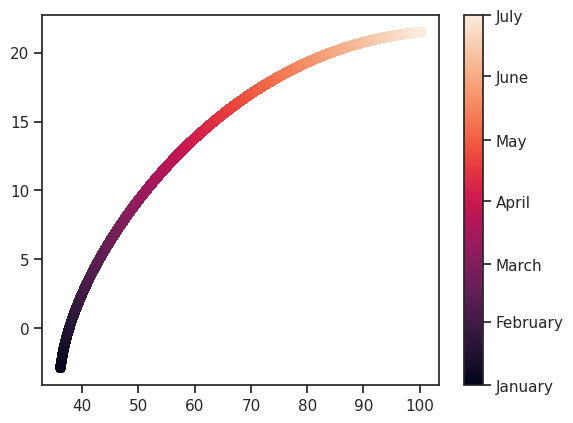

In [12]:
fig, ax = plt.subplots()

cax = plt.scatter(utils.unwind(ra_davida)/utils.degree, dec_davida/utils.degree, c=ts.unix)
cbar = fig.colorbar(cax, ticks=ts[month_flags].value)#, orientation='horizontal')
cbar.ax.set_yticklabels(months.values())
plt.show()

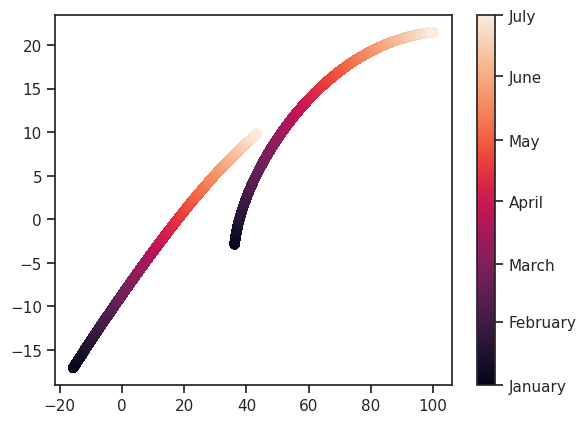

In [13]:
fig, ax = plt.subplots()

cax = plt.scatter(utils.unwind(ra_davida)/utils.degree, dec_davida/utils.degree, c=ts.unix)
cax = plt.scatter(utils.unwind(ra_diotima)/utils.degree, dec_diotima/utils.degree, c=ts.unix)
cbar = fig.colorbar(cax, ticks=ts[month_flags].value)#, orientation='horizontal')
cbar.ax.set_yticklabels(months.values())
plt.show()

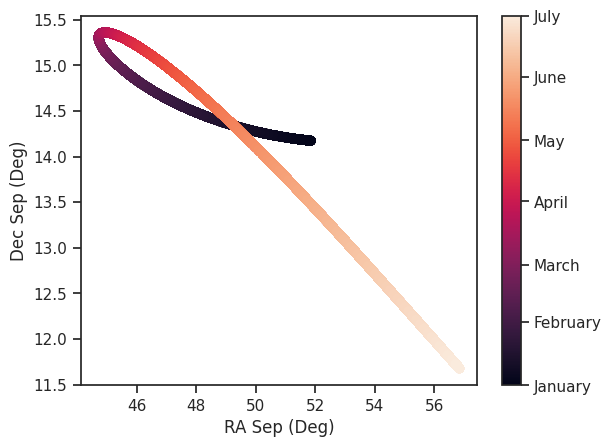

In [14]:
fig, ax = plt.subplots()

cax = plt.scatter(utils.unwind(ra_davida)/utils.degree - utils.unwind(ra_diotima)/utils.degree,
                  dec_davida/utils.degree - dec_diotima/utils.degree, c=ts.unix)
cbar = fig.colorbar(cax, ticks=ts[month_flags].value)#, orientation='horizontal')
cbar.ax.set_yticklabels(months.values())

plt.xlabel("RA Sep (Deg)")
plt.ylabel("Dec Sep (Deg)")
plt.show()

In [15]:
from astropy.coordinates import Angle
hms_ra_davida = Angle(np.mean(ra_davida), u.deg)
hms_dec_davida = Angle(np.mean(dec_davida), u.deg)

print(hms_ra_davida.hms, hms_dec_davida.dms)

hms_tuple(h=0.0, m=54.0, s=35.70561795202224) dms_tuple(d=0.0, m=12.0, s=30.90175691915249)


In [16]:
hms_ra_diotima = Angle(np.mean(ra_diotima), u.deg)
hms_dec_diotima = Angle(np.mean(dec_diotima), u.deg)

print(hms_ra_diotima.hms, hms_dec_diotima.dms)

hms_tuple(h=1.0, m=16.0, s=21.58341522476661) dms_tuple(d=-0.0, m=-2.0, s=-37.22938271095725)


# Plot Visibility

In [17]:
from datetime import datetime
import pandas as pd
import pytz

from astropy.table import Table

import observing_prep as obs

In [24]:
tz = pytz.timezone("America/New_York")
ts, flux_davida, err_davida, ra_davida, dec_davida = plot_lc(name, "2025-01-01T00:00:00.00","2025-07-02T00:00:00.00", ast_dir)

ts = Time(ts, format='unix', scale = 'utc')

In [35]:
sem_24B = [datetime(2024, 5, 1, tzinfo=tz), 
           datetime(2024, 6, 1, tzinfo=tz),
           datetime(2024, 7, 1, tzinfo=tz),
           datetime(2024, 8, 1, tzinfo=tz),
           datetime(2024, 9, 1, tzinfo=tz),
           datetime(2024, 10, 1, tzinfo=tz),
           datetime(2024, 11, 1, tzinfo=tz),
           datetime(2024, 12, 1, tzinfo=tz),
           datetime(2025, 1, 1, tzinfo=tz)]

sem_25A = [datetime(2025, 1, 1, tzinfo=tz), 
           datetime(2025, 2, 1, tzinfo=tz),
           datetime(2025, 3, 1, tzinfo=tz),
           datetime(2025, 4, 1, tzinfo=tz),
           datetime(2025, 5, 1, tzinfo=tz),
           datetime(2025, 6, 1, tzinfo=tz),
           datetime(2025, 7, 1, tzinfo=tz)]

#month_names = ["May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
month_names = ["January", "February", "March", "April", "May", "June"]

In [28]:
import time

"""
flags = np.zeros(len(sem_24B)-1, dtype=int)#No flag for January
for i, obs_time in enumerate(sem_24B):
    if i+1 == len(sem_24B): break #Skip January
    flag = np.where((np.abs(ts.unix-time.mktime(obs_time.timetuple()))<100))
    flags[i] = int(flag[0])
"""    
flags = np.zeros(len(sem_25A)-1, dtype=int)#No flag for January
for i, obs_time in enumerate(sem_25A):
    if i+1 == len(sem_25A): break
    flag = np.where((np.abs(ts.unix-time.mktime(obs_time.timetuple()))<100))
    flags[i] = int(flag[0][0])

In [36]:
d = {"RA": utils.unwind(ra_diotima[flags])/utils.degree, "Dec": dec_diotima[flags]/utils.degree*u.deg, 
     "Time": ts.unix[flags], "Name": month_names}

radec_table = pd.DataFrame(data=d)

2025-01-01 00:00:00-04:56
2025-02-01 00:00:00-04:56
2025-03-01 00:00:00-04:56
2025-04-01 00:00:00-04:56
2025-05-01 00:00:00-04:56
2025-06-01 00:00:00-04:56
2025-07-01 00:00:00-04:56


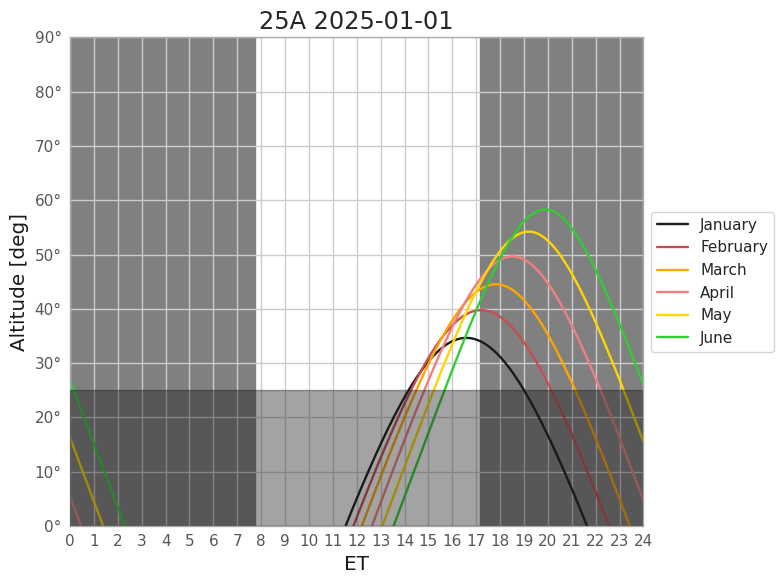

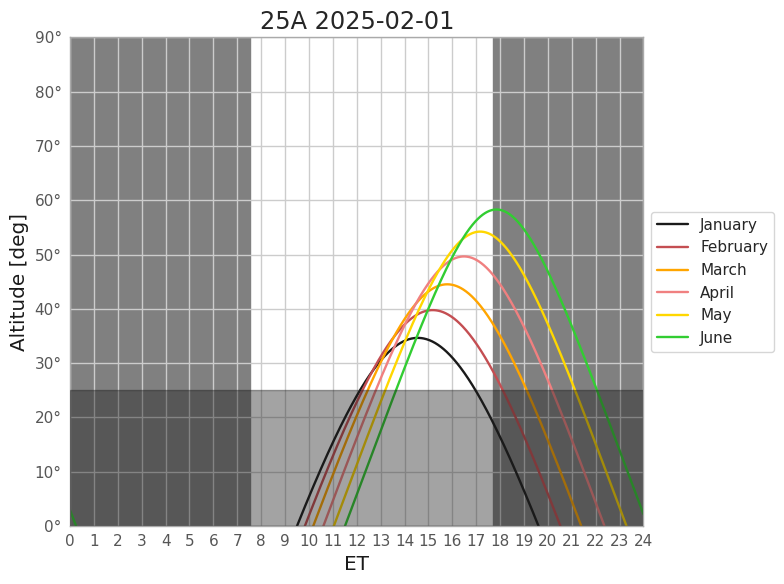

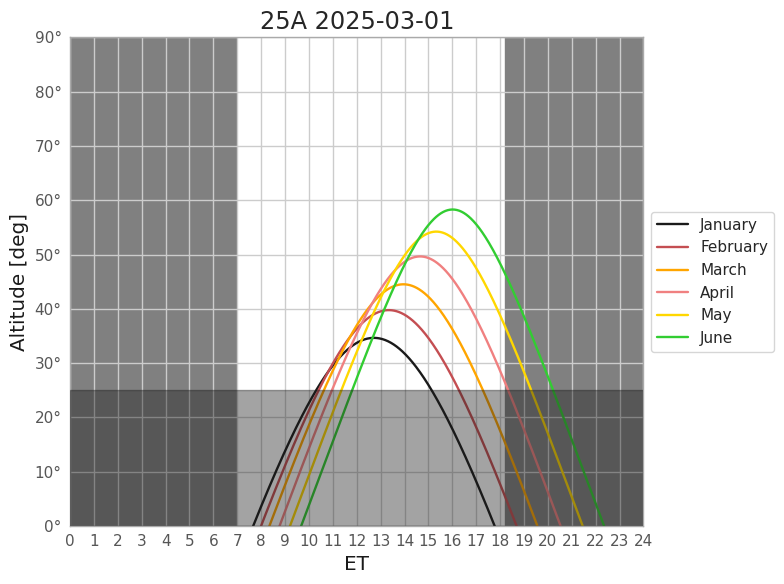

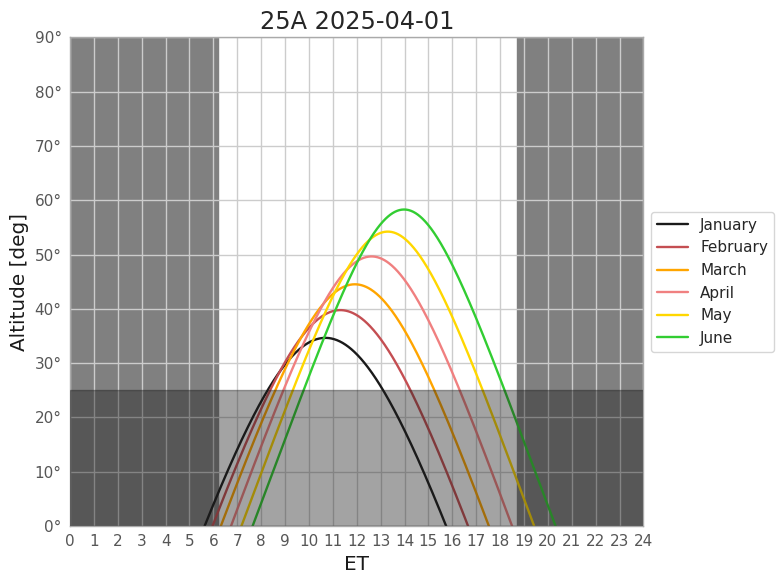

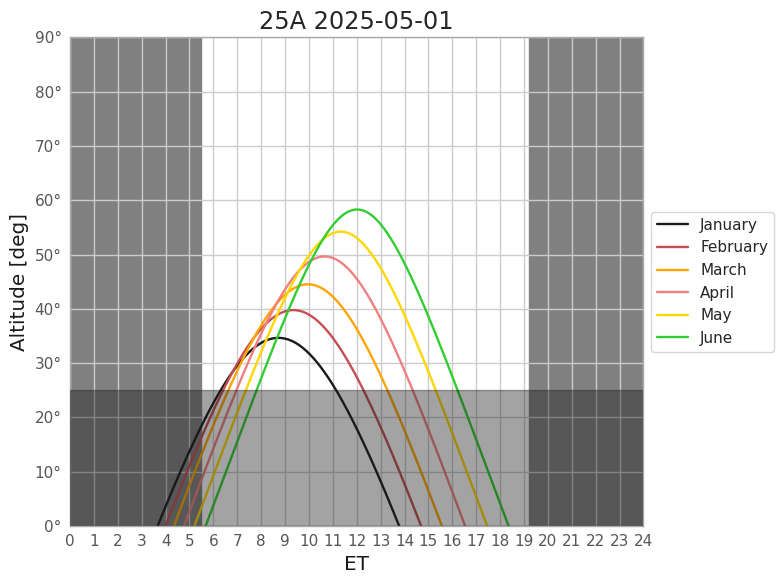

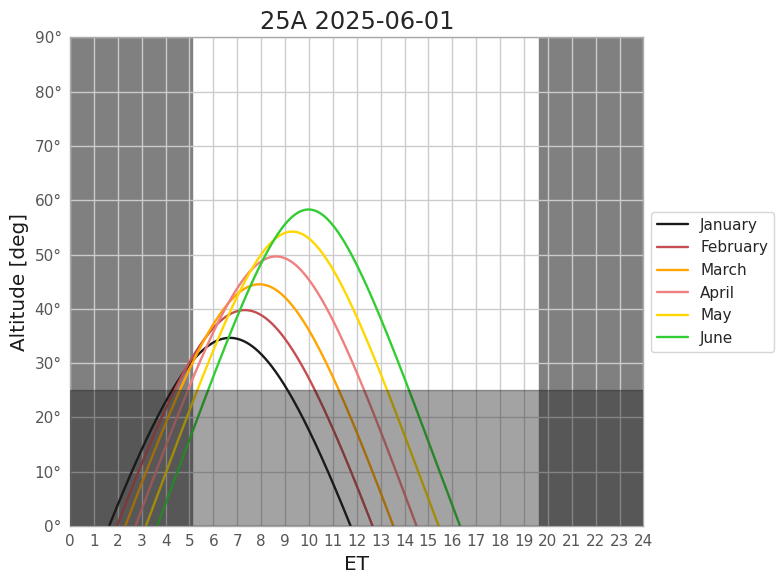

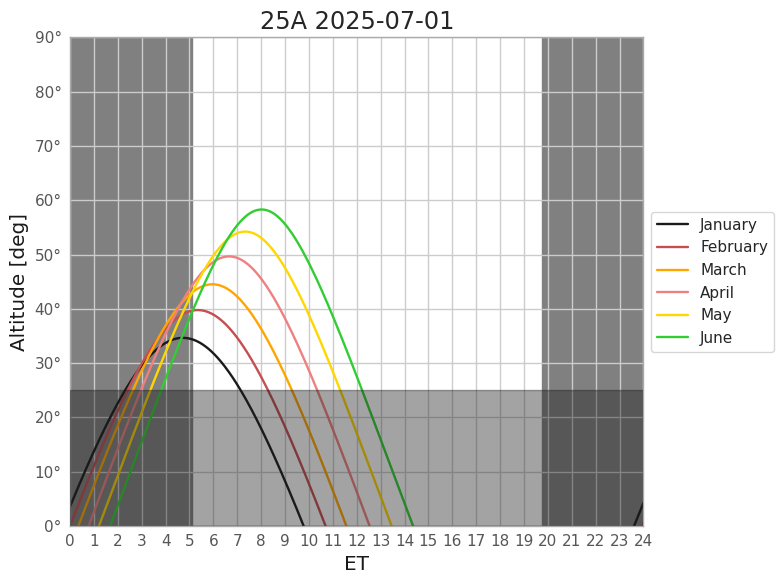

In [40]:
obs.visibilities_loop_days_and_objects(table_path = 'N/A',
                                        table=radec_table,
                                        telescope='GBT',
                                        time_zone='ET',
                                        dates=sem_25A,
                                        semester='25A',
                                        plot_suffix='_test_targets_',
                                        file_save_location='.')


2025-01-01 00:00:00-04:56
2025-02-01 00:00:00-04:56
2025-03-01 00:00:00-04:56
2025-04-01 00:00:00-04:56
2025-05-01 00:00:00-04:56
2025-06-01 00:00:00-04:56
2025-07-01 00:00:00-04:56


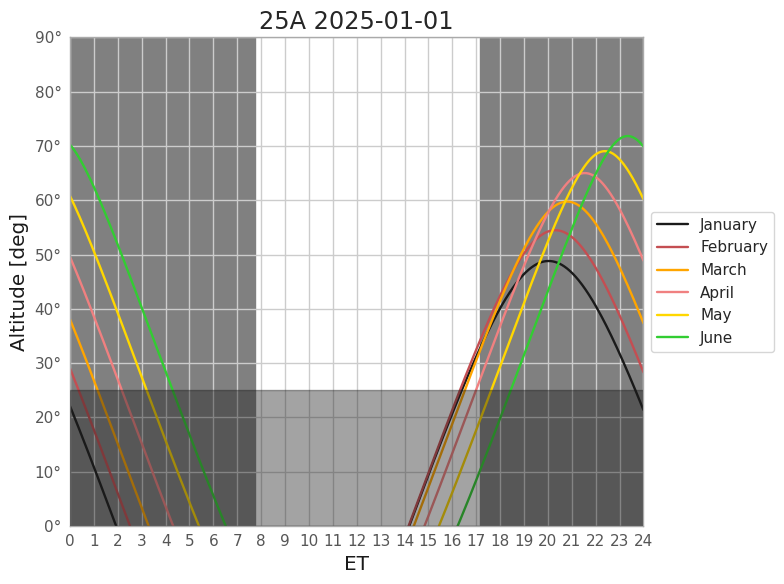

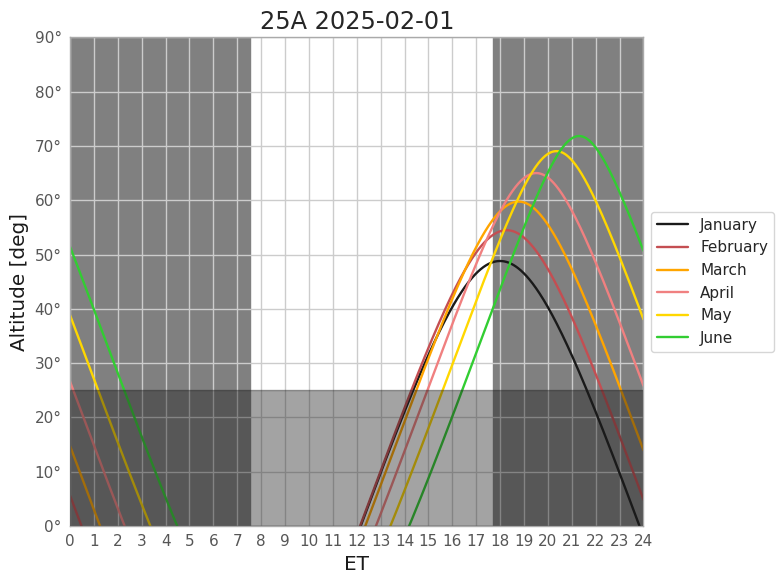

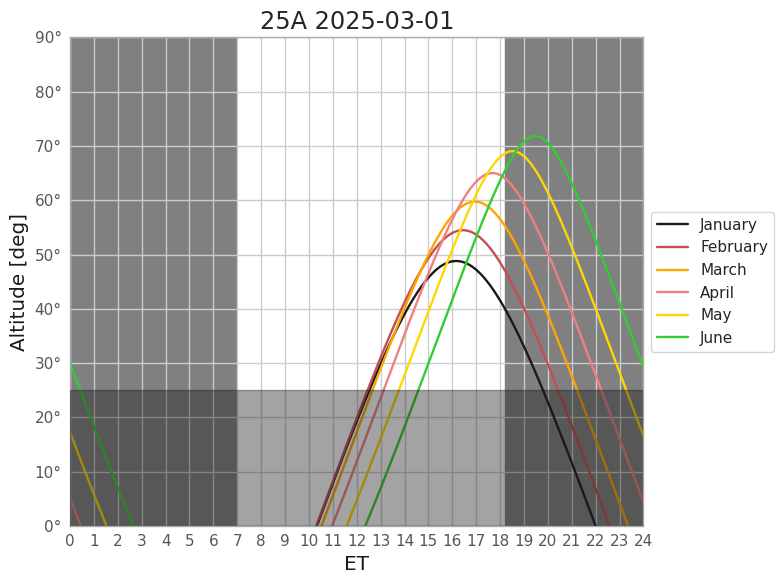

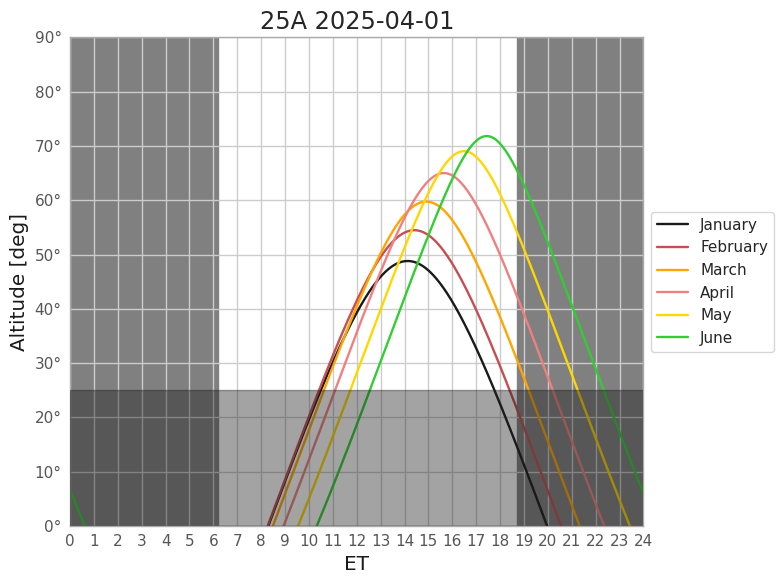

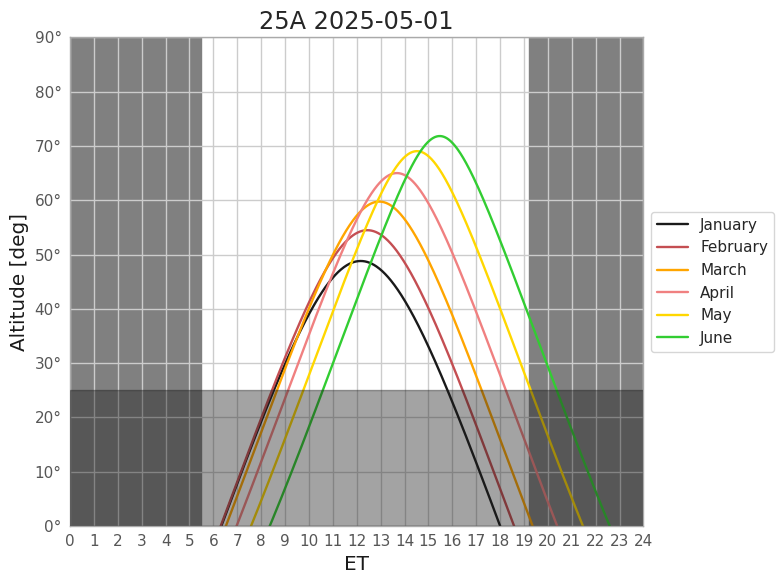

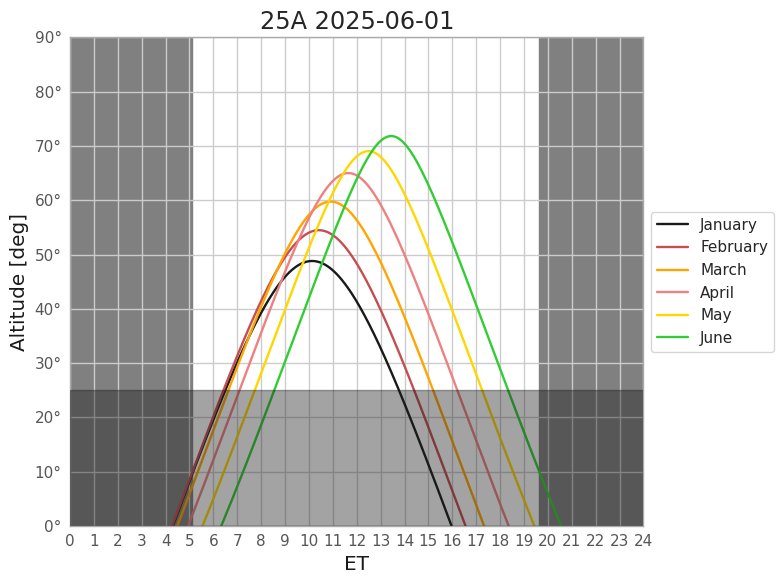

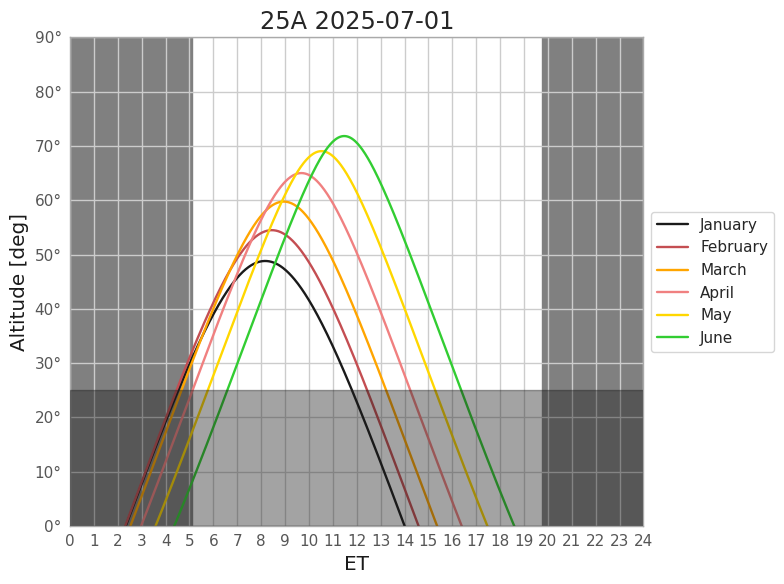

In [41]:
d = {"RA": utils.unwind(ra_davida[flags])/utils.degree, "Dec": dec_davida[flags]/utils.degree*u.deg, 
     "Time": ts.unix[flags], "Name": month_names}

radec_table = pd.DataFrame(data=d)
obs.visibilities_loop_days_and_objects(table_path = 'N/A',
                                        table=radec_table,
                                        telescope='GBT',
                                        time_zone='ET',
                                        dates=sem_25A,
                                        semester='25A',
                                        plot_suffix='_test_targets_',
                                        file_save_location='.')

# ALMA grid cals

In [ ]:
grid_cals = pd.read_csv("alma_gridcals.csv")

grid_cals = grid_cals.drop_duplicates(subset=['RA'])

In [ ]:
flux_cut = 1 #Jy

grid_cals = grid_cals.loc[grid_cals.Flux>flux_cut]
grid_cals = grid_cals.reset_index()

In [ ]:
for i in range(len(grid_cals)):
    dis = np.sqrt((ra_davida-grid_cals["RA"][i])**2+(dec_davida-grid_cals["DEC"][i])**2)
    if np.amin(dis) < 15:
        print(i, np.amin(dis))

In [ ]:
for i in range(len(grid_cals)):
    dis = np.sqrt((ra_diotima-grid_cals["RA"][i])**2+(dec_diotima-grid_cals["DEC"][i])**2)
    if np.amin(dis) < 25:
        print(i, np.amin(dis))

In [ ]:
flux_cals = pd.read_csv("alma_all_cals.csv")

flux_cals = flux_cals.drop_duplicates(subset=['RA'])

flux_cut = 0.5 #Jy

flux_cals = flux_cals.loc[flux_cals.Flux>flux_cut]
flux_cals = flux_cals.reset_index()

In [ ]:
for i in range(len(flux_cals)):
    dis = np.sqrt((ra_davida-flux_cals["RA"][i])**2+(dec_davida-flux_cals["Dec"][i])**2)
    if np.amin(dis) < 5:
        print(i, np.amin(dis))

In [ ]:
for i in range(len(flux_cals)):
    dis = np.sqrt((ra_diotima-flux_cals["RA"][i])**2+(dec_diotima-flux_cals["Dec"][i])**2)
    if np.amin(dis) < 5:
        print(i, np.amin(dis))